In [13]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Enhanced Optimization for Radar and Communications Applications 


The Low Autocorrelation Binary Sequences (LABS) is an important and challenging optimization problem with applications related to radar, telecommunications, and other signal related applications. This CUDA-Q Academic module will focus on a clever quantum-enhanced hybrid method developed in a collaboration between Kipu Quantum, University of the Basque Country EHU, and NVIDIA for solving the LABS problem. (This notebook was jointly developed with input from all collaborators.)

Other CUDA-Q Academic modules like [Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut) and [Quantum Finance](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb), demonstrate how quantum computing can be used outright to solve optimization problems. This notebook demonstrates a slightly different approach. Rather than considering QPUs as the tool to produce the final answer, it demonstrates how quantum can be used to enhance the effectiveness of leading classical methods.  

The benefits of such an approach were highlighted in [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1).  This notebook, co-created with the authors of the paper, will allow you to explore the findings of their research and write your own CUDA-Q code that builds a representative quantum-enhanced workflow for solving the LABS problem. Moreover, it will introduce advancements in counteradiabatic optimization techniques on which reduce the quantum resources required to run on a QPU.

**Prerequisites:** This lab assumes you have a basic knowledge of quantum computing, including operators, gates, etc.  For a refresher on some of these topics, explore the [Quick start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum) series.

**In this lab you will:**
* 1. Understand the LABS problem and its relation ot radar and communication applications.
* 2. Solve LABS classically with memetic tabu search and learn about the limitations of such methods.
* 3. Code a couteradiabatic algorithm using CUDA-Q to produce approximate solutions to the LABS problem.
* 4. Use the CUDA-Q results to seed your tabu search and understand the potential benefits of this approach.


**Terminology you will use:**
* Low autocorrelation of binary sequences (LABS)
* counteradiabatic optimization
* memetic-tabu search

**CUDA-Q Syntax you will use:**
* cudaq.sample()
* @cudaq.kernel
* ry(), rx(), rz(), x(), h() 
* x.ctrl()

Run the code below to initialize the libraries you will need.

In [14]:
import cudaq
import numpy as np
from math import floor
import auxiliary_files.labs_utils as utils

## The LABS problem and applications

The **Low Autocorrelation Binary Sequences (LABS)** problem is fundamental to many applications, but originated with applications to radar. 

Consider a radar that monitors airport traffic.  The radar signal sent to detect incoming planes must have as much range as possible to ensure safe approaches are planned well in advance.  The range of a radar signal can be increased by sending a longer pulse.  However, in order to differentiate between multiple objects, pulses need to be short to provide high resolution. So, how do you handle situations where you need both?

One solution is a technique called pulse compression.  The idea is to send a long signal, but vary the phase at regular intervals such that the resolution is increased. Generally, the initial signal will encode a binary sequence of phase shifts, where each interval corresponds to a signal with a 0 or 180 degree phase shift. 

The tricky part is selecting an optimal encoding sequence.  When the signal returns, it is fed into a matched filter with the hope that a singular sharp peak will appear, indicating clear detection.  The autocorrelation of the original signal, or how similar the signal is to itself,  determines if a single peak or a messier signal with sidelobes will be detected. A signal should have high autocorrelation when overlayed on top of itself, but low autocorrelation when shifted with a lag. 

Consider the image below.  The signal on the left has a crisp single peak while the single on the right produces many undesirable sidelobes which can inhibit clear detection.  

<img src="images/quantum_enhanced_optimization_LABS/radar.png" width="800">


So, how do you select a good signal?   This is where LABS comes in, defining these questions as a binary optimization problem. Given a binary sequence of length $N$, $(s_1 \cdots s_N) \in {\pm 1}^N$, the goal is to minimize the following objective function.

$$ E(s) = \sum_{k=1}^{N-1} C_k^2 $$

Where $C_k$ is defined as. 

 $$C_k= \sum_{i=1}^{N-k} s_is_{i+k}$$


So, each $C_k$ computes how similar the original signal is to the shifted one for each offset value $k$.  To explore this more, try the interactive widget linked [here](https://nvidia.github.io/cuda-q-academic/interactive_widgets/labs_visualization.html).  See if you can select a very good and very poor sequence and see the difference for the case of $N=7$.

## Classical Solution of the LABS problem

The LABS problem is tricky to solve for a few reasons. First, the configuration space grows exponentially.  Second, underlying symmetries of the problem result in many degeneracies in the optimization landscape severely inhibiting local search methods. 

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Using the widget above, try to find some of the symmetries for the LABS problem. That is, for a fixed bitstring length, can you find patterns to produce the same energy with different pulse patterns. 
</div>

The best known performance for a classical optimization technique is Memetic Tabu search (MTS) which exhibits a scaling of $O(1.34^N)$.  The MTS algorithm is depicted below.  It begins with a randomly selected population of bitstrings and finds the best solution from them.  Then, a child is selected by sampling directly from or combining multiple bitstrings from the population.  The child is mutated with probability $p_{mutate}$ and then input to a tabu search, which performs a modified greedy local search starting from the child bitstring.  If the result is better than the best in the population, it is updated as the new leader and randomly replaces a  bitstring in the population.


<img src="images/quantum_enhanced_optimization_LABS/mts_algorithm.png" width="500">

Such an approach is fast, parallelizable, and allows for exploration with improved searching of the solution landscape.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Before exploring any quantum approach, get a sense for how MTS works by coding it yourself based generally on the figure above. Algorithms for the combine and mutate steps are provided below as used in the paper. You may need to research more specific details of the process, especially for how tabu search is performed. The MTS procedure should output and optimal bitstring and its energy.  Also, write a function to visualize the results including the energy distribution of the final population.
</div>



<img src="images/quantum_enhanced_optimization_LABS/combine_mutate.png" width="400">



N=7 global minE and maxE (by brute force): 3 91
--- Very good (global optimal) ---
bits: 0001101
E: 3
Ck k=1..6: [0, -1, 0, -1, 0, -1]
aperiodic autocorr lags -6..+6: [-1, 0, -1, 0, -1, 0, 7, 0, -1, 0, -1, 0, -1]

--- Very poor (max energy) ---
bits: 0000000
E: 91
Ck k=1..6: [6, 5, 4, 3, 2, 1]
aperiodic autocorr lags -6..+6: [1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1]

[MTS    50] best_E=372  elapsed=56.05s
[MTS   100] best_E=372  elapsed=112.10s
[MTS   150] best_E=368  elapsed=168.20s
[MTS   200] best_E=316  elapsed=224.17s
[MTS   250] best_E=316  elapsed=280.15s
[MTS   300] best_E=316  elapsed=335.95s
[MTS   350] best_E=316  elapsed=391.85s
[MTS   400] best_E=316  elapsed=447.77s
Best E: 316
Best bitstring (0/1): 1001001011011011101010001000100101010010000001111100001110011100
Elapsed (s): 447.774


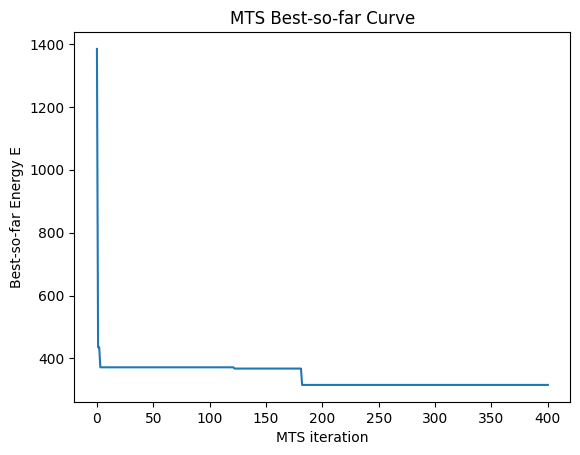

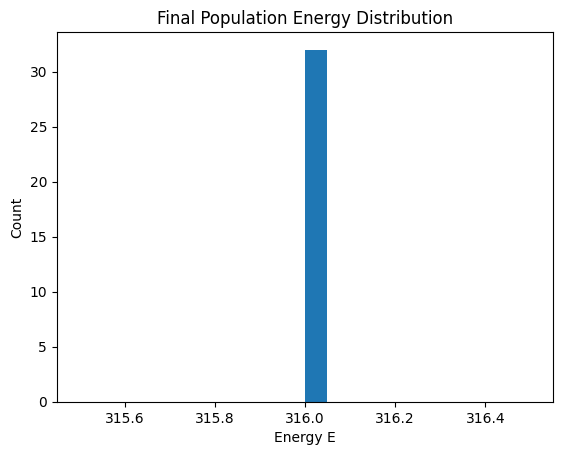

In [15]:
#TODO - Write code to perform MTS
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools

# 1) LABS objective for ±1 sequences

def pm1_to_bits01(s_pm1: np.ndarray) -> np.ndarray:
    return ((s_pm1 + 1) // 2).astype(np.int8)

def bits01_to_pm1(bits01) -> np.ndarray:
    x = np.array(bits01, dtype=np.int8)
    return (2*x - 1).astype(np.int8)  # 0->-1, 1->+1

def labs_correlations_pm1(s: np.ndarray) -> np.ndarray:
    """C[k-1] = C_k for k=1..N-1, C_k = sum_i s[i]*s[i+k]."""
    N = s.size
    C = np.empty(N-1, dtype=np.int32)
    for k in range(1, N):
        C[k-1] = int(np.dot(s[:-k], s[k:]))
    return C

def labs_energy_from_C(C: np.ndarray) -> int:
    C64 = C.astype(np.int64)
    return int(np.sum(C64*C64))

def labs_energy_pm1(s: np.ndarray) -> int:
    return labs_energy_from_C(labs_correlations_pm1(s))

def aperiodic_autocorr_full(s_pm1: np.ndarray) -> np.ndarray:
    """lags = -(N-1)..+(N-1)"""
    N = len(s_pm1)
    out = []
    for lag in range(-(N-1), N):
        if lag < 0:
            out.append(int(np.dot(s_pm1[-lag:], s_pm1[:N+lag])))
        elif lag == 0:
            out.append(int(np.dot(s_pm1, s_pm1)))
        else:
            out.append(int(np.dot(s_pm1[:-lag], s_pm1[lag:])))
    return np.array(out, dtype=int)


# 2) Algorithm 3: Combine & Mutate (as in your screenshot)


def combine_alg3(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    N = p1.size
    k = int(rng.integers(1, N))  # k in {1,...,N-1}
    child = np.empty_like(p1)
    child[:k] = p1[:k]
    child[k:] = p2[k:]
    return child

def mutate_alg3(s: np.ndarray, p_mut: float, rng: np.random.Generator) -> np.ndarray:
    out = s.copy()
    if p_mut <= 0.0:
        return out
    mask = rng.random(out.size) < p_mut
    out[mask] *= -1
    return out

# 3) Tabu Search (single-bit flip neighborhood)
#    - aspiration: allow tabu move if it improves best found in this tabu run
#    - candidate_size: evaluate subset of flips each step (CPU-friendly)


def delta_energy_single_flip_pm1(s: np.ndarray, C: np.ndarray, E: int, j: int):
    """
    After flipping s[j], update correlations deltaC and energy E_new.
    Flip affects C_k terms that involve index j:
      (j, j+k) and (j-k, j) when in bounds.
    Each affected product changes sign => delta contribution = -2*old_term.
    """
    N = s.size
    sj = int(s[j])
    deltaC = np.zeros_like(C, dtype=np.int32)

    for k in range(1, N):
        d = 0
        jp = j + k
        jm = j - k
        if jp < N:
            d += sj * int(s[jp])
        if jm >= 0:
            d += int(s[jm]) * sj
        if d != 0:
            deltaC[k-1] = -2 * d

    C64 = C.astype(np.int64)
    d64 = deltaC.astype(np.int64)
    dE = int(np.sum(2*C64*d64 + d64*d64))
    return E + dE, deltaC

def tabu_search_pm1(
    s0: np.ndarray,
    max_iters: int = 1000,
    tabu_tenure: int = 30,
    candidate_size: int = 64,
    rng: np.random.Generator | None = None,
):
    if rng is None:
        rng = np.random.default_rng()

    s = s0.copy()
    C = labs_correlations_pm1(s)
    E = labs_energy_from_C(C)

    best_s = s.copy()
    best_E = int(E)

    N = s.size
    tabu_until = np.zeros(N, dtype=np.int32)

    for it in range(1, max_iters + 1):
        # choose candidate flip indices
        if candidate_size >= N:
            candidates = np.arange(N)
        else:
            candidates = rng.choice(N, size=candidate_size, replace=False)

        chosen_j = None
        chosen_E = None
        chosen_dC = None

        # pick best admissible (tabu allowed only if aspiration)
        for j in candidates:
            E_new, dC = delta_energy_single_flip_pm1(s, C, E, int(j))
            is_tabu = tabu_until[j] > it
            if is_tabu and (E_new >= best_E):
                continue
            if (chosen_E is None) or (E_new < chosen_E):
                chosen_j, chosen_E, chosen_dC = int(j), int(E_new), dC

        # if all were blocked, ignore tabu
        if chosen_j is None:
            for j in candidates:
                E_new, dC = delta_energy_single_flip_pm1(s, C, E, int(j))
                if (chosen_E is None) or (E_new < chosen_E):
                    chosen_j, chosen_E, chosen_dC = int(j), int(E_new), dC

        # apply flip
        s[chosen_j] *= -1
        C += chosen_dC
        E = chosen_E

        # update tabu tenure (with slight randomness)
        tenure = tabu_tenure + int(rng.integers(0, max(1, tabu_tenure // 3)))
        tabu_until[chosen_j] = it + tenure

        if E < best_E:
            best_E = int(E)
            best_s = s.copy()

    return best_s, best_E


# 4) MTS main loop (matches your diagram)

def mts_labs_pm1(
    N: int,
    pop_size: int = 32,
    p_combine: float = 0.7,
    p_mut: float = 1.0/50.0,
    mts_iters: int = 1000,
    tabu_iters: int = 800,
    tabu_tenure: int = 30,
    candidate_size: int = 64,
    target_E: int | None = None,
    seed: int = 0,
    verbose_every: int = 100,
):
    rng = np.random.default_rng(seed)

    # init population: k random bitstrings
    pop = rng.choice(np.array([-1, 1], dtype=np.int8), size=(pop_size, N))
    pop_E = np.array([labs_energy_pm1(pop[i]) for i in range(pop_size)], dtype=np.int64)

    best_idx = int(np.argmin(pop_E))
    best_s = pop[best_idx].copy()
    best_E = int(pop_E[best_idx])

    trace = [best_E]
    t0 = time.time()

    for it in range(1, mts_iters + 1):
        if target_E is not None and best_E <= target_E:
            break

        # ---- Make Child ----
        if rng.random() < p_combine:
            i1, i2 = rng.integers(0, pop_size, size=2)
            child = combine_alg3(pop[i1], pop[i2], rng)
        else:
            i = int(rng.integers(0, pop_size))
            child = pop[i].copy()

        # ---- Mutate Child ----
        child = mutate_alg3(child, p_mut, rng)

        # ---- Tabu Search with Child ----
        result_s, result_E = tabu_search_pm1(
            child,
            max_iters=tabu_iters,
            tabu_tenure=tabu_tenure,
            candidate_size=candidate_size,
            rng=rng,
        )

        # ---- Update best solution ----
        if result_E < best_E:
            best_E = int(result_E)
            best_s = result_s.copy()

        # ---- Add result to Population ----
        # randomly replace a member if result is better
        r = int(rng.integers(0, pop_size))
        if result_E < pop_E[r]:
            pop[r] = result_s
            pop_E[r] = result_E

        # (optional, helpful) elitism: keep global best in population
        worst = int(np.argmax(pop_E))
        if best_E < pop_E[worst]:
            pop[worst] = best_s
            pop_E[worst] = best_E

        trace.append(best_E)

        if verbose_every and (it % verbose_every == 0):
            print(f"[MTS {it:5d}] best_E={best_E}  elapsed={time.time()-t0:.2f}s")

    return {
        "best_s_pm1": best_s,
        "best_s_01": pm1_to_bits01(best_s),
        "best_E": best_E,
        "best_trace": np.array(trace, dtype=np.int64),
        "population_pm1": pop,
        "population_E": pop_E.copy(),
        "elapsed_sec": time.time() - t0,
    }


# 5) Visualization: best curve + final population energy distribution

def visualize_mts(res: dict):
    print("Best E:", res["best_E"])
    print("Best bitstring (0/1):", "".join(map(str, res["best_s_01"].tolist())))
    print("Elapsed (s):", f"{res['elapsed_sec']:.3f}")

    trace = res["best_trace"]
    popE = res["population_E"]

    plt.figure()
    plt.plot(trace)
    plt.xlabel("MTS iteration")
    plt.ylabel("Best-so-far Energy E")
    plt.title("MTS Best-so-far Curve")
    plt.show()

    plt.figure()
    plt.hist(popE, bins=20)
    plt.xlabel("Energy E")
    plt.ylabel("Count")
    plt.title("Final Population Energy Distribution")
    plt.show()


#  N=7: show a very good and very poor sequence difference


def brute_best_worst_N7():
    N = 7
    rows = []
    for bits in itertools.product([0,1], repeat=N):
        s = bits01_to_pm1(bits)
        E = labs_energy_pm1(s)
        rows.append((bits, E))
    minE = min(E for _,E in rows)
    maxE = max(E for _,E in rows)
    good = [b for b,E in rows if E==minE][0]
    bad  = [b for b,E in rows if E==maxE][0]

    def show(bits, title):
        s = bits01_to_pm1(bits)
        C = labs_correlations_pm1(s)
        E = labs_energy_pm1(s)
        ac = aperiodic_autocorr_full(s)
        print(f"--- {title} ---")
        print("bits:", "".join(map(str,bits)))
        print("E:", E)
        print("Ck k=1..6:", C.tolist())
        print("aperiodic autocorr lags -6..+6:", ac.tolist())
        print()

    print("N=7 global minE and maxE (by brute force):", minE, maxE)
    show(good, "Very good (global optimal)")
    show(bad, "Very poor (max energy)")
    

# Example runs


# 1) N=7 demo (good vs poor)
brute_best_worst_N7()

# 2) Run MTS (CPU baseline) - start small
N = 64
res = mts_labs_pm1(
    N=N,
    pop_size=32,
    p_combine=0.7,
    p_mut=1.0/50.0,
    mts_iters=400,
    tabu_iters=800,
    tabu_tenure=30,
    candidate_size=64,
    seed=42,
    verbose_every=50,
)
visualize_mts(res)


## Building a Quantum Enhanced Workflow

Despite the effectiveness of MTS, it still exhibits exponential scaling  $O(1.34^N)$ behavior and becomes intractable for large $N$.  Quantum computing provides a potential alternative method for solving the LABS problem because the properties of entanglement, interference, and superpositon may allow for a better global search.  Recent demonstrations have even produced evidence that the quantum approximate optimization algorithm (QAOA) can be used to reduce the scaling of the LABS problem to $O(1.21^N)$ for $N$ between 28 and 40 with quantum minimum finding.

However, current quantum hardware limitations restrict solution to problems of greater than about $N=20$, meaning that it will be some time before quantum approaches can outperform the classical state of the art. It should also be noted that standard QAOA can struggle with LABS and require many layers to converge the parameters if other tricks are not employed.

The authors of [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1) cleverly explored an alternate path that combines quantum and classical approaches and might be able to provide a more near-term benefit.  Instead of expecting the quantum computer to solve the problem entirely, they asked how a quantum approach might enhance MTS.

The basic idea is that a quantum optimization routine could run first and the resulting state be sampled to produce a better population for MTS. Many such heuristics for defining the initial population are possible, but the rest of this notebook will explore their methodology, help you to build the workflow yourself, and allow you to analyze the benefits of their approach.

The first step of quantum enhanced MTS (QE-MTS) is to prepare a circuit with CUDA-Q that approximates the ground state of the Hamiltonian corresponding to the LABS problem. You could do this with any optimization algorithm such as QAOA or using an adiabatic approach.  (See the [Quantum Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb) CUDA-Q Academic lab for a detailed comparison of these two common approaches.)

The authors of this work opted for an adiabatic approach (More on why later). Recall that the goal of an adiabatic optimization is to begin with a Hamiltonian that has an easily prepared ground state ($H_i$). Then, the adiabatic Hamiltonian $H_{ad}$ can be constructed as $H_{ad}(\lambda) = (1-\lambda)H_i +\lambda H_f $, where $\lambda$ is a function of time and $H_f$ is the Hamiltonian representing a qubit encoding of the LABS problem. 

$$H_f = 2 \sum_{i=1}^{N-2} \sigma_i^z \sum_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} \sigma_{i+k}^z 
+ 4 \sum_{i=1}^{N-3} \sigma_i^z \sum_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \sum_{k=t+1}^{N-i-t} \sigma_{i+t}^z \sigma_{i+k}^z \sigma_{i+k+t}^z$$

The authors also selected $H_i = \sum_i h^x_i \sigma^x_i $ which has an easily prepared ground state of $\ket{+}^{\otimes N}$.

The challenge for implementing the optimization procedure becomes selection of an operator that will quickly and accurately evolve to the ground state of $H_f$.  One approach is to use a so-called auxiliary countradiabatic (CD) term $H_{CD}$, which corrects diabatic transitions that jump out of the ground state during the evolution. The figure below demonstrates the benefit of using a CD correction.


<img src="images/quantum_enhanced_optimization_LABS/counteradiabatic.png" width="900">




An operator called the adiabatic gauge potential $A_{\lambda}$ is the ideal choice for the CD term as it suppresses all possible diabatic transitions, resulting in the following total system to evolve.

$$ H(\lambda) = H_{ad}(\lambda) + \lambda H_{CD} (\lambda) $$

$A(\lambda)$ is derrived from $H_{ad}(\lambda)$  (see paper for details) as it contains information about underlying physics of the problem. 

There is a problem though.  The $A(\lambda)$ term cannot be efficiently expressed exactly and needs to be approximated.  It also turns out that in the so called impulse regime, where the adiabatic evolution is very fast, $H_{cd} (\lambda)$ dominates $H_{ad}(\lambda)$, meaning that the final implementation corresponds to the operator $H(\lambda) = H^1_{cd}(\lambda)$ where  $H^1_{cd}(\lambda)$ is a first order approximation of $A(\lambda)$ (see equation 7 in the paper).

A final step is to use Trotterization to define the quantum circuit to apply $e^{-\theta (t) i H_{cd}}$. The details for this derivation are shown in the appendix of the paper. and result from equation B3 is shown below.  

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

It turns out that this implementation is more efficient than QAOA in terms of gate count. The authors calculated that for $N=67$, QAOA would require 1.4 million entangling gates while the CD approach derived here requires only 236 thousand entangling gates.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
At first glance, this equation might looks quite complicated. However, observe the structure and note two "blocks" of terms.  Can you spot them?  

They are 2 qubit terms that look like $R_{YZ}(\theta)$ or $R_{ZY}(\theta)$.

As well as 4 qubit terms that look like $R_{YZZZ}(\theta)$, $R_{ZYZZ}(\theta)$, $R_{ZZYZ}(\theta)$, or $R_{ZZZY}(\theta)$.

Thankfully the authors derive a pair of circuit implementations for the two and four qubit terms respectively, shown in the figures below.

Using CUDA-Q, write a kernel for each which will be used later to construct the full implementation.

* Hint: Remember that the adjoint of a rotation gate is the same as rotating in the opposite direction. 

* Hint: You may also want to define a CUDA-Q kernel for an R$_{ZZ}$ gate.

* Hint: Implementing a circuit from a paper is a great place where AI can help accelerate your work.  If you have access to a coding assistant, feel free to use it here.
</div>

<img src="images/quantum_enhanced_optimization_LABS/kernels.png" width="1300">


In [20]:
# TODO  Write CUDA-Q kernels to apply the 2 and 4 qubit operators.
# define rzz
@cudaq.kernel
def rzz(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):# for pi/2
    x.ctrl(q0, q1)    
    rz(theta, q1)    
    x.ctrl(q0, q1)

@cudaq.kernel
def two_qubit_rotation_block(q0: cudaq.qubit, q1: cudaq.qubit, theta: float):
    pi = np.pi
    rx(pi/2.0, q1)
    rzz(q0, q1, theta)
    rx(pi/2.0, q0)
    rx(-pi/2.0, q1)
    rzz(q0, q1, theta)
    rx(-pi/2.0, q0)

@cudaq.kernel
def four_qubit_rotation_block(q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit, theta: float):
    pi = np.pi
    rx(-pi/2.0, q0)
    ry(pi/2.0, q1)
    ry(-pi/2.0, q2)
    
    rzz(q0, q1, -pi/2.0)
    rzz(q2, q3, -pi/2.0)

    rx(pi/2.0, q0)
    ry(-pi/2.0, q1) 
    ry(pi/2.0, q2)
    rx(-pi/2.0, q3) 

    rx(-pi/2.0, q1) 
    rx(-pi/2.0, q2) 
    
    rzz(q1, q2, theta)

    rx(pi/2.0, q1) 
    rx(pi, q2) 

    ry(pi/2.0, q1)
    
    rzz(q0, q1, pi/2.0)
    
    rx(pi/2.0, q0)
    ry(-pi/2.0, q2) 
    
    rzz(q1, q2, -theta)
    
    rx(pi/2.0, q1)
    rx(-pi, q2) 
    
    rzz(q1, q2, -theta)
    
    rx(-pi, q1)
    ry(pi/2.0, q2)
    
    rzz(q2, q3, -pi/2.0)
    
    ry(-pi/2.0, q2) # Ry_dagger
    rx(-pi/2.0, q3)

    rx(-pi/2.0, q2)
    
    rzz(q1, q2, theta)

    rx(pi/2.0, q1)
    rx(pi/2.0, q2)
    
    ry(-pi/2.0, q1)
    ry(pi/2.0, q2)
    
    rzz(q0, q1, pi/2.0)
    rzz(q2, q3, pi/2.0)

    
    ry(pi/2.0, q1)
    ry(-pi/2.0, q2)
    rx(pi/2.0, q3)

There are a few additional items we need to consider before completing the final implementation of the entire circuit.  One simplification we can make is that for our problem the $h_i^x$ terms are all 1 and any $h_b^x$ terms are 0, and are only there for generalizations of this model. 

The remaining challenge is derivation of the angles that are used to apply each of the circuits you defined above. These are obtained from two terms $\lambda(t)$ and $\alpha(t)$.  


The $\lambda(t)$ defines an annealing schedule and is generally a Sin function which slowly "turns on" the problem Hamiltonian.  For computing our angles, we need the derivative of $\lambda(t)$.

The $\alpha$ term is a bit trickier and is the solution to a set of differential equations which minimize the distance between $H^1_{CD}(\lambda)$ and $A(\lambda)$.  The result is 

$$\alpha(t) = \frac{-\Gamma_1(t)}{\Gamma_2(t)} $$

Where $\Gamma_1(t)$ and $\Gamma_2(t)$ are defined in equations 16 and 17 of the paper and essentially depend on the structure of the optimization problem.  Curious learners can look at the functions in `labs_utils.py`  to see how these are computed, based on the problem size and specific time step in the Trotter process. 


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
The `compute_theta` function, called in the following cells, requires all indices of the two and four body terms. These will be used again in our main kernel to apply the respective gates.  Use the products in the formula below to finish the function in the cell below.  Save them as `G2` and `G4` where each is a list of lists of indices defining the two and four term interactions. As you are translating an equation to a set of loops, this is a great opportunity to use an AI coding assistant.

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

</div>


In [21]:
def get_interactions(N: int):
    """
    Generates the interaction sets G2 and G4 based on the loop limits in Eq.15 (noted in the notebook).
    Returns standard 0-based indices as lists of lists of ints.

    Args:
        N (int): Sequence length.

    Returns:
        G2: List of [i, i+k] two-body index pairs (0-based).
        G4: List of [i, i+t, i+k, i+k+t] four-body index quadruples (0-based).
    """
    if not isinstance(N, int) or N < 4:
        # N must be at least 4 for non-empty G4; G2 exists for N>=3, but we choose N>=4 here as safe min.
        raise ValueError("N must be an integer >= 4")

    G2 = []
    G4 = []

    # Build G2
    # 1-based loops in the guide: i = 1..N-2, k = 1..floor((N-i)/2)
    # Convert to 0-based: i0 = i-1 in range(0, N-2), k runs 1..floor((N-(i))/2)
    for i0 in range(0, N - 2):  # i0 corresponds to i=1..N-2
        max_k = (N - (i0 + 1)) // 2  # floor((N-i)/2) where i = i0+1
        for k in range(1, max_k + 1):
            j0 = i0 + k
            # sanity: ensure indices inside [0, N-1]
            if 0 <= j0 < N:
                G2.append([i0, j0])

    # Build G4
    # 1-based loops in the guide: i = 1..N-3, t = 1..floor((N-i-1)/2), k = t+1..N-i-t
    # Convert to 0-based: i0 in 0..N-4, t,k as below.
    for i0 in range(0, N - 3):  # i0 corresponds to i=1..N-3
        max_t = (N - (i0 + 1) - 1) // 2  # floor((N-i-1)/2) with i=i0+1
        for t in range(1, max_t + 1):
            # k loop (1-based): k = t+1 .. N - i - t
            # convert bounds to 0-based arithmetic: iterate over k in that integer range
            k_min = t + 1
            k_max = (N - (i0 + 1) - t)  # inclusive in 1-based formula
            # k_min..k_max (both inclusive) in 1-based; iterate accordingly
            for k in range(k_min, k_max + 1):
                # map to 0-based indices for the four-body term:
                # (i, i+t, i+k, i+k+t) in 1-based -> subtract 1 for 0-based:
                a = i0
                b = i0 + t
                c = i0 + k
                d = i0 + k + t
                # ensure within bounds
                if 0 <= a < N and 0 <= b < N and 0 <= c < N and 0 <= d < N:
                    G4.append([a, b, c, d])

    # Sanity checks (counts)
    # expected_G2_len = sum_{i=1}^{N-2} floor((N-i)/2)
    expected_G2 = sum(((N - i) // 2) for i in range(1, N - 1))
    # expected_G4_len = sum_{i=1}^{N-3} sum_{t=1}^{floor((N-i-1)/2)} (N - i - 2*t)
    expected_G4 = 0
    for i in range(1, N - 2):
        max_t = (N - i - 1) // 2
        for t in range(1, max_t + 1):
            expected_G4 += max(0, N - i - 2 * t)

    assert len(G2) == expected_G2, f"G2 length mismatch: got {len(G2)}, expected {expected_G2}"
    assert len(G4) == expected_G4, f"G4 length mismatch: got {len(G4)}, expected {expected_G4}"

    return G2, G4


# Quick usage example/smoke test:

if __name__ == "__main__":
    for Ntest in [6, 7, 8, 10]:
        G2, G4 = get_interactions(Ntest)
        print(f"N={Ntest}: |G2|={len(G2)}, |G4|={len(G4)}")
        # print a few examples
        print(" G2 sample:", G2[:6])
        print(" G4 sample:", G4[:6])
        print("-" * 40)


N=6: |G2|=6, |G4|=7
 G2 sample: [[0, 1], [0, 2], [1, 2], [1, 3], [2, 3], [3, 4]]
 G4 sample: [[0, 1, 2, 3], [0, 1, 3, 4], [0, 1, 4, 5], [0, 2, 3, 5], [1, 2, 3, 4], [1, 2, 4, 5]]
----------------------------------------
N=7: |G2|=9, |G4|=13
 G2 sample: [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]
 G4 sample: [[0, 1, 2, 3], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 5, 6], [0, 2, 3, 5], [0, 2, 4, 6]]
----------------------------------------
N=8: |G2|=12, |G4|=22
 G2 sample: [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [1, 4]]
 G4 sample: [[0, 1, 2, 3], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 5, 6], [0, 1, 6, 7], [0, 2, 3, 5]]
----------------------------------------
N=10: |G2|=20, |G4|=50
 G2 sample: [[0, 1], [0, 2], [0, 3], [0, 4], [1, 2], [1, 3]]
 G4 sample: [[0, 1, 2, 3], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 5, 6], [0, 1, 6, 7], [0, 1, 7, 8]]
----------------------------------------




<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
You are now ready to construct the entire circuit and run the counteradiabatic optimization procedure. The final kernel needs to apply Equation 15 for a specified total evolution time $T$ and the `n_steps` number of Trotter steps.  It must also take as input, the indices for the two and four body terms and the thetas to be applied each step, as these cannot be computed within a CUDA-Q kernel.

The helper function `compute_theta` computes the theta parameters for you, using a few additional functions in accordance with the equations defined in the paper.
</div>


In [ ]:
@cudaq.kernel
def trotterized_circuit(N: int, G2: list[list[int]], G4: list[list[int]], steps: int, dt: float, T: float, thetas: list[float]):
    
    reg = cudaq.qvector(N)
    h(reg)

    nums_g2 = len(G2)
    nums_g4 = len(G4)
    items = nums_g2 + nums_g4
    
    for n in range(steps): # fomula:[1, n]
        step_offset = step * items
        for i in range(nums_g2):
            pair = G2[i] # fomula:[1,N-2] for i and # [1,(N - i) // 2 ] for k
            theta = thetas[step_offset + i]
            two_qubit_rotation_block(reg[pair[0]], reg[pair[1]], theta)
            
        for j in range(nums_g4):#[1,N-3] for j;#[1,(N-i-1)/2] for t and #[t+1,N-i-t]for k
            quad = G4[j]
            theta = thetas[step_offset + nums_g2 + j] # for in utils.compute_theta, the pair appair before quad
            four_qubit_rotation_block(reg[quad[0]], reg[quad[1]], reg[quad[2]], reg[quad[3]], theta) 
    mz(reg)

# test it
T=1               # total time
n_steps = 1       # number of trotter steps
dt = T / n_steps
N = 20
G2, G4 = get_interactions(N)

thetas =[]

for step in range(1, n_steps + 1):
    t = step * dt
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

# TODO - Sample your kernel to make sure it works
counts = cudaq.sample(trotterized_circuit, N, G2, G4, n_steps, dt, T, thetas)

print("Completed!")
print(counts.most_probable())

## Generating Quantum Enhanced Results

Recall that the point of this lab is to demonstrate the potential benefits of running a quantum subroutine as a preprocessing step for classical optimization of a challenging problem like LABS. you now have all of the tools you need to try this for yourself.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
Use your CUDA-Q code to prepare an initial population for your memetic search algorithm and see if you can improve the results relative to a random initial population.  If you are running on a CPU, you will need to run smaller problem instances. The code below sets up the problem

</div>


In [ ]:
# TODO - write code here to sample from your CUDA-Q kernel and used the results to seed your MTS population

The results clearly show that a population sampled from CUDA-Q results in an improved distribution and a lower energy final result. This is exactly the goal of quantum enhanced optimization.  To not necessarily solve the problem, but improve the effectiveness of state-of-the-art classical approaches. 

A few major caveats need to be mentioned here. First, We are comparing a quantum generated population to a random sample.  It is quite likely that other classical or quantum heuristics could be used to produce an initial population that might even beat the counteradiabatic method you used, so we cannot make any claims that this is the best. 

Recall that the point of the counteradiabatic approach derived in the paper is that it is more efficient in terms of two-qubit gates relative to QAOA. The benefits of this regime would only truly come into play in a setting (e.g. larger problem instance) where it is too difficult to produce a good initial population with any know classical heuristic, and the counteradiabatic approach is more efficiently run on a QPU compared to alternatives.

We should also note that we are comparing a single sample of each approach.  Maybe the quantum sample got lucky or the randomly generated population was unlucky and a more rigorous comparison would need to repeat the analysis many times to draw any confidently conclusions.  

The authors of the paper discuss all of these considerations, but propose an analysis that is quite interesting related to the scaling of the technique. Rather than run large simulations ourselves, examine their results below. 


<img src="images/quantum_enhanced_optimization_LABS/tabu_search_results.png" width="900">

The authors computed replicate median (median of solving the problem repeated with same setup) time to solutions (excluding time to sample from QPU) for problem sizes $N=27$ to $N=37$. Two interesting conclusions can be drawn from this. First, standard memetic tabu search (MTS) is generally faster than quantum enhanced (QE) MTS.  But there are two promising trends. For larger problems, the QE-MTS experiments occasionally have excellent performance with times to solution much smaller than all of the MTS data points.  These outliers indicate there are certain instances where QE-MTS could provide much faster time-to-solution. 

More importantly, if a line of best fit is calculated using the median of each set of medians, the slope of the QE-MTS line is smaller than the MTS!  This seems to indicate that QE solution of this problem scales $O(1.24^N)$ which is better than the best known classical heuristic ($O(1.34^N)$) and the best known quantum approach (QAOA - $O(1.46^N)$).

For problems of size of $N=47$ or greater, the authors anticipate that QE-MTS could be a promising technique and produce good initial populations that are difficult to obtain classically. 

The study reinforces the potential of hybrid workflows enhanced by quantum data such that a classical routine is still the primary solver, but quantum computers make it much more effective.  Future work can explore improvements to both the quantum and classical sides, such as including GPU accelerated memetic search on the classical side.

## Self-validation To Be Completed for Phase 1

In this section, explain how you verified your results. Did you calculate solutions by hand for small N? Did you create unit tests? Did you cross-reference your Quantum energy values against your Classical MTS results? Did you check known symmetries?